## Robot@Home 2 - Making a video `v0.1`

`R@H2 notebook series`   

<a href="https://colab.research.google.com/github/goyoambrosio/RobotAtHome2/blob/master/notebooks/50-RGBD-observations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>



### R@H2 functions introduced in this notebook:



-   `get_RGBD_sensor_size`
-   `get_RGBD_fps`
-   `get_path_vars`


### Getting started



Install Robot@Home2 Toolbox using the Python package manager



In [ ]:
!pip install robotathome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, let's mount Google Drive (more info in [this notebook](https://colab.research.google.com/github/goyoambrosio/RobotAtHome2/blob/master/notebooks/05-Google-colab-drive.ipynb)) and instantiate the RobotAtHome class.

In [ ]:
from google.colab import drive
from robotathome import RobotAtHome
from robotathome import logger, log, set_log_level

# Let's mount Google Drive
drive.mount('/content/drive')

# Then copy the provided configutarion file to the current directory (/content)
!cp /content/drive/MyDrive/R@H2-2.0.3/notebooks/.rh .

# And create an instance of the RobotAtHome class
try: 
      rh = RobotAtHome()
except:
      logger.error("Something was wrong")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2023-04-17 13:48:43.404 | SUCCESS  | robotathome.core.reader:__open_dataset:141 - Connection is established: rh.db


### Iterating over RGBD images coming from multiple cameras




We already know how to iterate over RGBD images coming from multiple cameras. We continue from the previous example where we have build a main loop to iterate and concatenate images.

In [ ]:
from robotathome import filter_sensor_observations
from robotathome import composed_RGBD_images
from robotathome import concat_images
from robotathome import process_image

# cv2 causes some trouble to Colab so they provide a patch
# Usually you'll write: from cv2 import imshow
from google.colab.patches import cv2_imshow

log.set_log_level('INFO')  # SUCCESS is the default

# Fill the variables that constitutes selection filter
home_session_name = 'alma-s1'
home_subsession = 0
room_name = 'alma_masterroom1'
sensor_list = ['RGBD_3', 'RGBD_4', 'RGBD_1', 'RGBD_2'] # Left to right order

# Get the labeled RGB-D observations dataframe
df = rh.get_sensor_observations('lblrgbd')

# Filter the dataframe and get a dictionary with a dataframe per sensor
df_dict = filter_sensor_observations(rh, df,
                                     home_session_name,
                                     home_subsession,
                                     room_name,
                                     sensor_list)

logger.info(f"Labeled RGBD set: {len(df)} observations")
for sensor_name in sensor_list:
    logger.info(f"No. of RGBD observations int the filtered subset for the sensor {sensor_name}: {len(df_dict[sensor_name])} observations")

2023-04-17 13:48:43.645 | INFO     | __main__:<cell line: 28>:28 - Labeled RGBD set: 32937 observations
2023-04-17 13:48:43.647 | INFO     | __main__:<cell line: 29>:30 - No. of RGBD observations int the filtered subset for the sensor RGBD_3: 299 observations
2023-04-17 13:48:43.649 | INFO     | __main__:<cell line: 29>:30 - No. of RGBD observations int the filtered subset for the sensor RGBD_4: 299 observations
2023-04-17 13:48:43.651 | INFO     | __main__:<cell line: 29>:30 - No. of RGBD observations int the filtered subset for the sensor RGBD_1: 299 observations
2023-04-17 13:48:43.652 | INFO     | __main__:<cell line: 29>:30 - No. of RGBD observations int the filtered subset for the sensor RGBD_2: 299 observations


In Google Colab, reading files from the mounted drive takes time, so for this example we will select only a few images.

In [ ]:
# For this example, we will only select a few images
df_RGBD_N_only_some_frames = {}
for sensor_name in sensor_list:
    df_RGBD_N_only_some_frames[sensor_name] = df_dict[sensor_name][30:40] # ~ 1 sec

As we already know, the iteration is carried out through a main loop.

```
# Iterate over the dictionary of dataframes, i.e. frame by frame
for (RGB_image_dict, D_image_dict) in composed_RGBD_images(rh, df_RGBD_N_only_some_frames):
    def f(img_dict):
        return my_function(img_dict, par1,... parn)
        
    # Apply f to img_dict
    resulting_img = process_image(f, RGB_image_dict)
```





### Making the video

Making a video with the concatenated images is not a complex task. We need to write a function to get a video handler:

In [ ]:
import cv2 as cv

def get_rh_video_handler(rh_dataset, filename, sensor_names):
    """Return a video handler."""
    sensor_size = rh_dataset.get_RGBD_sensor_size()
    fourcc = cv.VideoWriter_fourcc(*'MJPG')
    out = cv.VideoWriter(filename,
                          fourcc,
                          rh_dataset.get_RGBD_fps(),
                          (len(sensor_names)*sensor_size['w'], sensor_size['h']))
    return out


In the previous cell we have introduced two functions: `get_RGBD_sensor_size` and `get_RGBD_fps`.

`get_RGBD_sensor_size` returns a dictionary with the size of camera sensors in pixels

In [ ]:
print(rh.get_RGBD_sensor_size())

{'w': 240, 'h': 320}


Regarding `get_RGBD_fps`, the function returns the frame rate of the cameras based on the timestamps associated with each observation (i.e. with each image). The fps of each camera can vary slightly but this function returns the average fps for the four cameras. 

In [ ]:
# Get fps for cameras set
print(rh.get_RGBD_fps())

10.72


Now, it's time to write the main loop to iterate over images. In this example, the images from cameras are concatenated and the resulting image is added to the video.

In [ ]:
video_filename = 'myvideo.avi'

 # Getting video handler
video_handler = get_rh_video_handler(rh,
                                     video_filename, #video_path_filename,
                                     sensor_list)

# Iterate over the dictionary of dataframes, i.e. frame by frame
for (RGB_image_dict, D_image_dict) in composed_RGBD_images(rh, df_RGBD_N_only_some_frames):
    def f(img_dict):
        # return my_function(img_dict, par1,... parn)
        return concat_images(img_dict)

    # Apply f to img_dict
    resulting_img = process_image(f, RGB_image_dict)
    # 
    video_handler.write(resulting_img)
# Closing video file
video_handler.release()

The video is created in the current folder:

In [ ]:
!pwd

/content


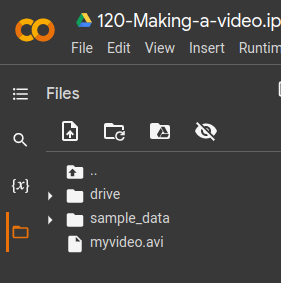

You can pass an absolute or relative file path to `get_rh_video_handler` but to avoid issues in Google Colab we recommend you to move the generated file later: 

In [ ]:
[_, _, _, wspc_path, _] = rh.get_path_vars()
!cp $video_filename $wspc_path
!ls $wspc_path/*.avi

'/content/drive/MyDrive/Colab Notebooks/myvideo.avi'


Note that `get_path_vars` returns a list with the values read from the config file.